#**유통 판매량 예측 및 재고 최적화**
## **단계1 : 데이터 탐색 및 가설 도출**

# **0.미션**

* 예측해야 할 핵심상품 역할 분담
    * 핵심상품 별로, 데이터 탐색, 가설수립, 데이터셋 구성
    * 1인당 1~2개 정도를 분담하여 개별 과제 수행
    * 팀 미팅을 통해 진행 사항 공유 및 취합

* 데이터 탐색 및 가설 도출
    * 주어진 데이터에 대해 대상 매장, 대상 상품의 그래프 그리고 시계열 패턴을 찾기
    * 찾은 패턴을 기반으로 가설 도출

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/KT Aivle/Mini Project 6-1/'

### **(2) 라이브러리 설치 및 불러오기**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

### **(3) 데이터 불러오기**

#### 1) 데이터로딩

In [4]:
oil_price = pd.read_csv(path + 'train/oil_price_train.csv')
orders = pd.read_csv(path + 'train/orders_train.csv')
sales = pd.read_csv(path + 'train/sales_train.csv')
products = pd.read_csv(path + 'train/products.csv')
stores = pd.read_csv(path + 'train/stores.csv')

sales['Date'] = pd.to_datetime(sales['Date'] )
oil_price['Date'] = pd.to_datetime(oil_price['Date'] )
orders['Date'] = pd.to_datetime(orders['Date'] )

In [5]:
sales['Date'].min(), sales['Date'].max()

(Timestamp('2014-01-01 00:00:00'), Timestamp('2017-02-28 00:00:00'))

#### 2) 기본 정보 조회

In [6]:
oil_price.head()

,Date,WTI_Price
0,2014-01-01,NaN
1,2014-01-02,95.14
2,2014-01-03,93.66
3,2014-01-06,93.12
4,2014-01-07,93.31


In [7]:
products.head()

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,20,HG001,Gardening Tools,Household Goods,2,50
1,27,HH001,Home Appliances,Household Goods,2,150
2,16,HK001,Kitchen,Household Goods,2,23
3,15,HK002,Kitchen,Household Goods,2,41
4,32,GS001,Seafood,Grocery,3,34


In [8]:
sales.head()

,Date,Store_ID,Qty,Product_ID
0,2014-01-01,1,0.0,3
1,2014-01-01,1,0.0,5
2,2014-01-01,1,0.0,7
3,2014-01-01,1,0.0,8
4,2014-01-01,1,0.0,10


In [9]:
orders.head()

,Date,Store_ID,CustomerCount
0,2014-01-01,25,840
1,2014-01-01,36,487
2,2014-01-02,1,1875
3,2014-01-02,2,2122
4,2014-01-02,3,3350


# **2.데이터 탐색**

* 시계열 패턴을 찾아보기 위한 그래프를 그려 봅시다.

## **(1) 시계열 패턴 찾아보기1**

* 다음 항목은 패턴을 찾기 위한 예제 문항 입니다. 참조하여 시계열 패턴을 찾아 봅시다.
    * 대상 매장(44), 대상 상품(3,12,42)의 판매량 추이
    * 대상 상품의 동일 카테고리의 상품별 판매량 추이
    * 휘발류 가격과 상품 판매량 추이 비교
    * 방문 고객수와 상품 판매량 추이 비교
    * 그외...

### 1) 대상 매장(44), 대상 상품의 판매량 추이

In [21]:
def sales_trends_prod(Product_ID, sdate, edate):
    display(products.loc[products['Product_ID']==Product_ID])
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    plt.figure(figsize = (12,4))
    sns.lineplot(x='Date', y = 'Qty', data = temp)
    plt.grid()
    plt.show()

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
13,3,DB001,Beverage,Drink,2,8


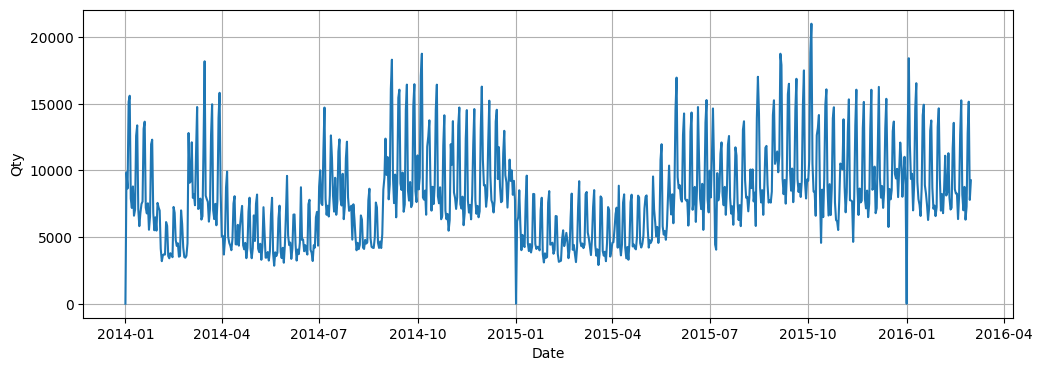

In [20]:
# Beverage
sales_trends_prod(3, '2014-01-01', '2016-03-01')

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
14,12,GA001,Milk,Food,3,6


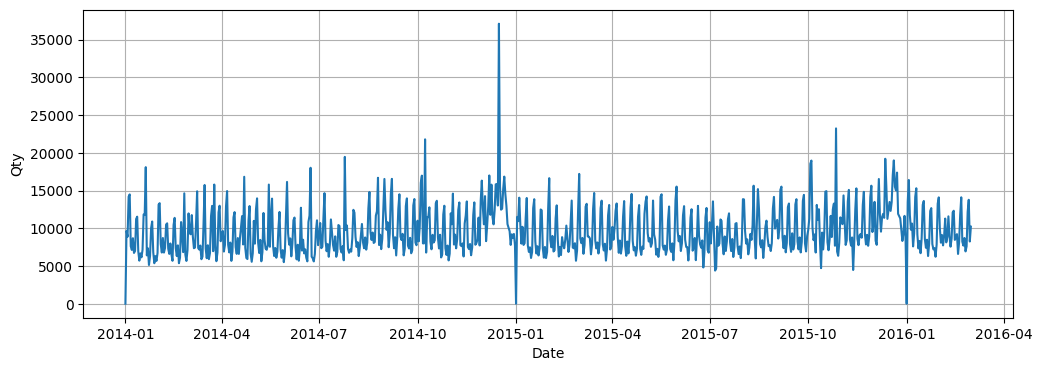

In [ ]:
# Milk
sales_trends_prod(12, '2014-01-01', '2016-03-01')

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
15,42,FM001,Agricultural products,Grocery,3,5


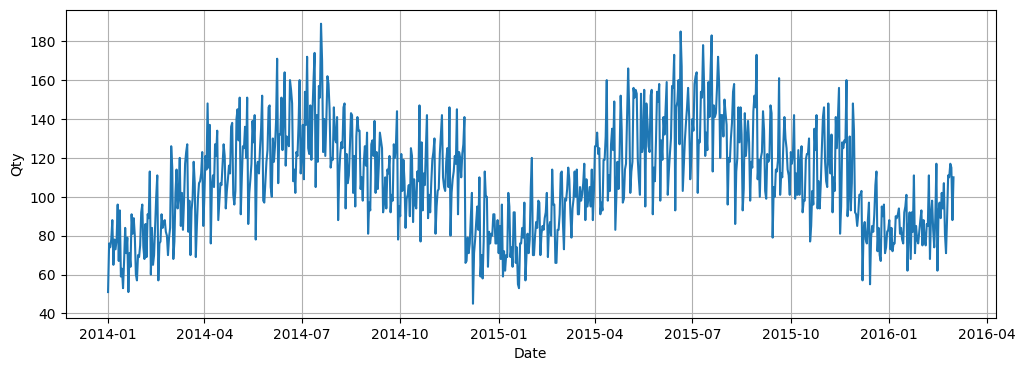

In [ ]:
# Agricultural Products
sales_trends_prod(42, '2014-01-01', '2016-03-01')

### 2) 대상 상품의 동일 카테고리의 상품별 판매량 추이

In [24]:
products

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
0,20,HG001,Gardening Tools,Household Goods,2,50
1,27,HH001,Home Appliances,Household Goods,2,150
2,16,HK001,Kitchen,Household Goods,2,23
3,15,HK002,Kitchen,Household Goods,2,41
4,32,GS001,Seafood,Grocery,3,34
5,38,DA001,Wine,Drink,2,12
6,29,FP001,Prepared,Food,2,18
7,11,FF001,Frozen,Food,2,29
8,10,GE001,EGGS,Grocery,2,5
9,24,GM001,Meats,Grocery,3,17


In [44]:
def sales_trends_category(Product_ID, sdate, edate, each = 0):
    Category = products.loc[products['Product_ID']==Product_ID, 'Category'].to_list()
    Product_IDs = products.loc[products['Category'].isin(Category), 'Product_ID'].to_list()
    display(products.loc[products['Category'].isin(Category)].sort_values('Product_ID'))

    temp1 = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'].isin(Product_IDs)) & (sales['Date'].between(sdate, edate))].groupby(['Date', 'Product_ID'], as_index = False)['Qty'].sum()
    temp1['Product_ID'] = pd.Categorical(temp1['Product_ID'])

    plt.figure(figsize = (12,4))
    sns.lineplot(x='Date', y = 'Qty', data = temp1, hue = 'Product_ID')
    plt.grid()
    plt.show()

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
13,3,DB001,Beverage,Drink,2,8
5,38,DA001,Wine,Drink,2,12


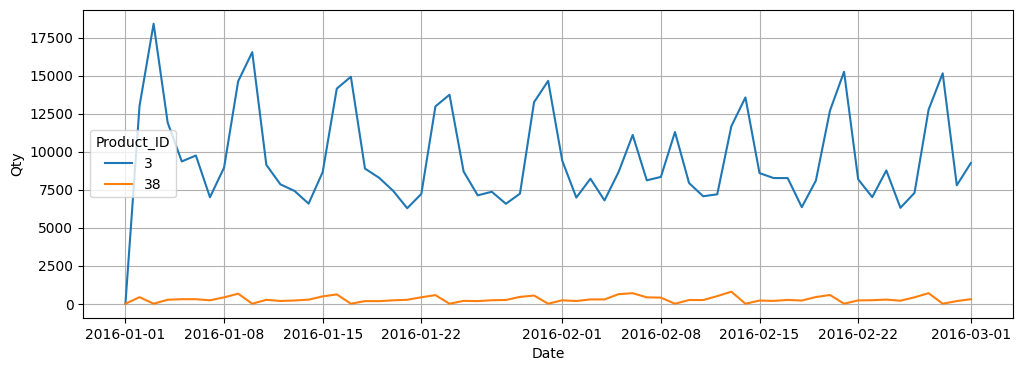

In [45]:
sales_trends_category(3, '2016-01-01', '2016-03-01')

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
10,5,FB001,BAKERY,Food,2,6
11,8,FM001,Yogurt,Food,2,4
7,11,FF001,Frozen,Food,2,29
14,12,GA001,Milk,Food,3,6
6,29,FP001,Prepared,Food,2,18


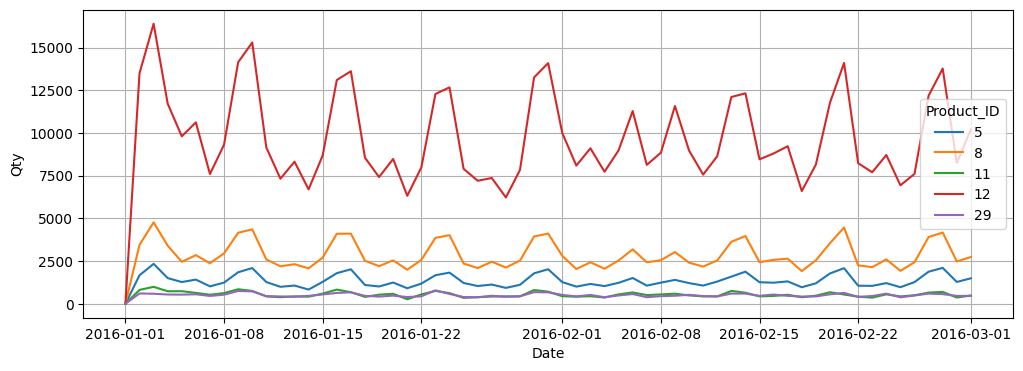

In [ ]:
sales_trends_category(12, '2016-01-01', '2016-03-01')

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
8,10,GE001,EGGS,Grocery,2,5
9,24,GM001,Meats,Grocery,3,17
4,32,GS001,Seafood,Grocery,3,34
15,42,FM001,Agricultural products,Grocery,3,5


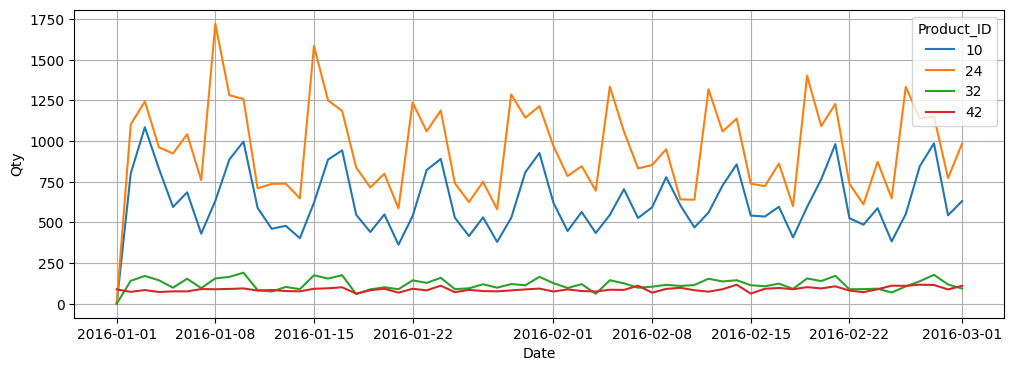

In [ ]:
sales_trends_category(42, '2016-01-01', '2016-03-01')

### 3) 휘발류 가격과 상품 판매량 추이 비교

In [ ]:
def oil_trends_product(Product_ID, sdate, edate):
    display( products.loc[products['Product_ID'].isin([Product_ID])])

    temp1 = oil_price.loc[oil_price['Date'].between(sdate, edate)]
    temp2 = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]

    plt.figure(figsize = (12,8))
    plt.subplot(2,1,1)
    sns.lineplot(x='Date', y = 'WTI_Price', data = temp1)
    plt.grid()

    plt.subplot(2,1,2)
    sns.lineplot(x='Date', y = 'Qty', data = temp2)
    plt.grid()
    plt.show()

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
13,3,DB001,Beverage,Drink,2,8


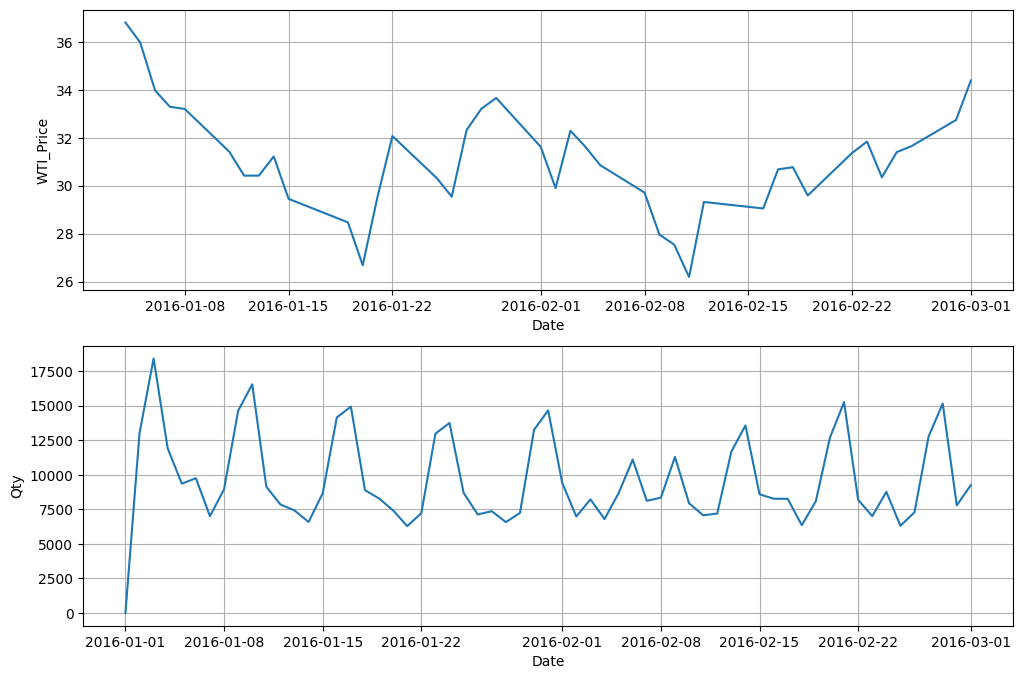

In [ ]:
oil_trends_product(3, '2016-01-01', '2016-03-01')

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
14,12,GA001,Milk,Food,3,6


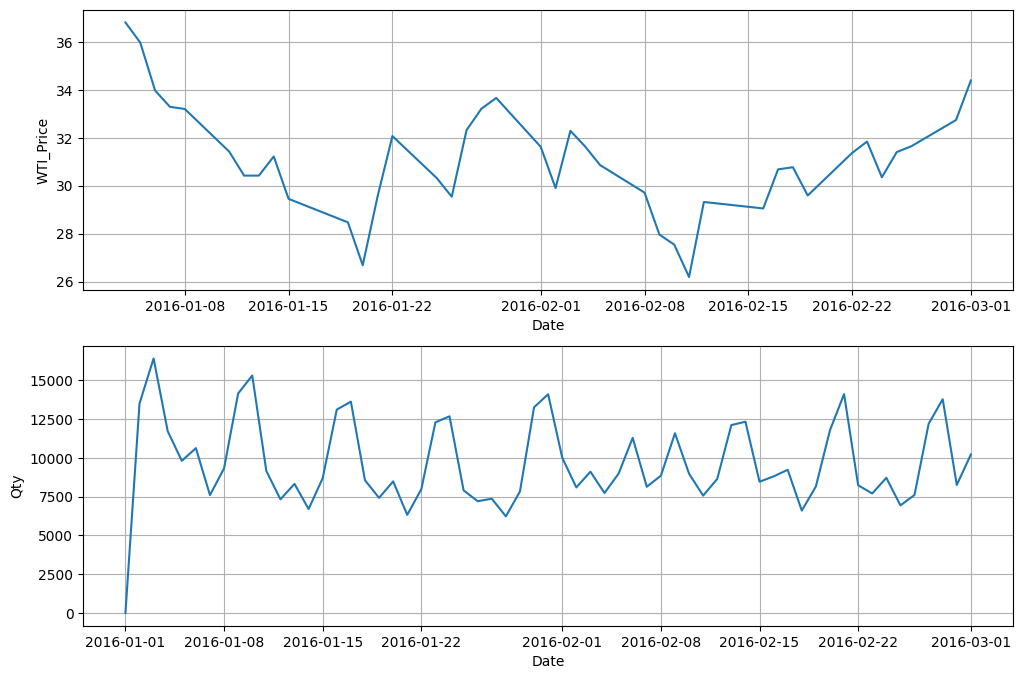

In [ ]:
oil_trends_product(12, '2016-01-01', '2016-03-01')

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
15,42,FM001,Agricultural products,Grocery,3,5


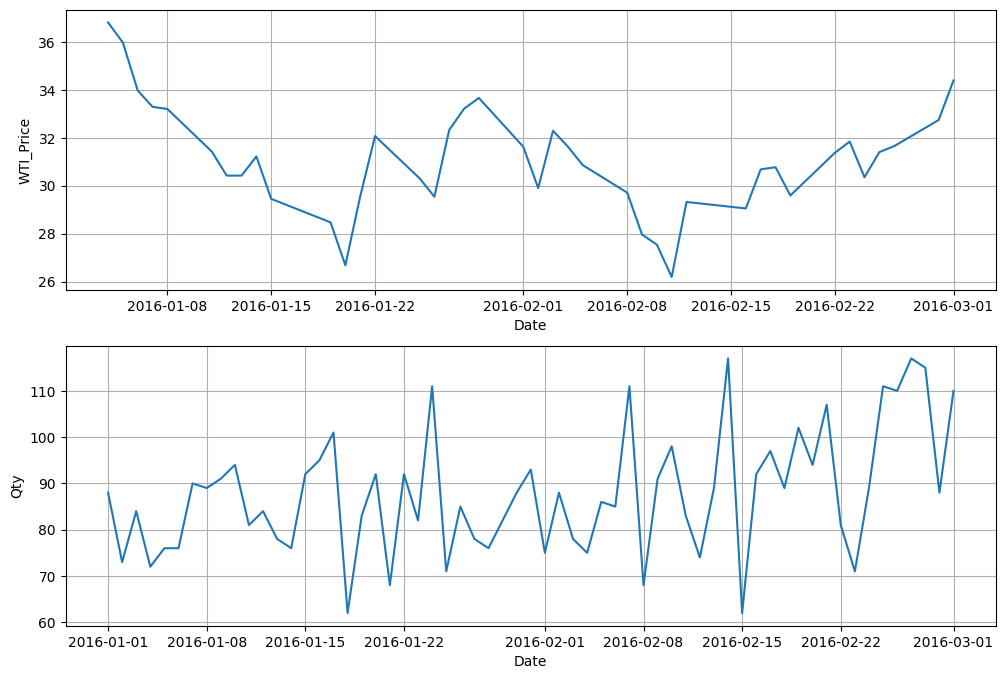

In [ ]:
oil_trends_product(42, '2016-01-01', '2016-03-01')

### 4) 방문 고객수와 상품 판매량 추이 비교

In [ ]:
def custCount_trends_product(Product_ID, sdate, edate):
    display( products.loc[products['Product_ID'].isin([Product_ID])])

    temp1 = orders.loc[ (orders['Store_ID'] == 44) & orders['Date'].between(sdate, edate)]
    temp2 = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]

    plt.figure(figsize = (12,8))
    plt.subplot(2,1,1)
    sns.lineplot(x='Date', y = 'CustomerCount', data = temp1)
    plt.grid()

    plt.subplot(2,1,2)
    sns.lineplot(x='Date', y = 'Qty', data = temp2)
    plt.grid()
    plt.show()

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
13,3,DB001,Beverage,Drink,2,8


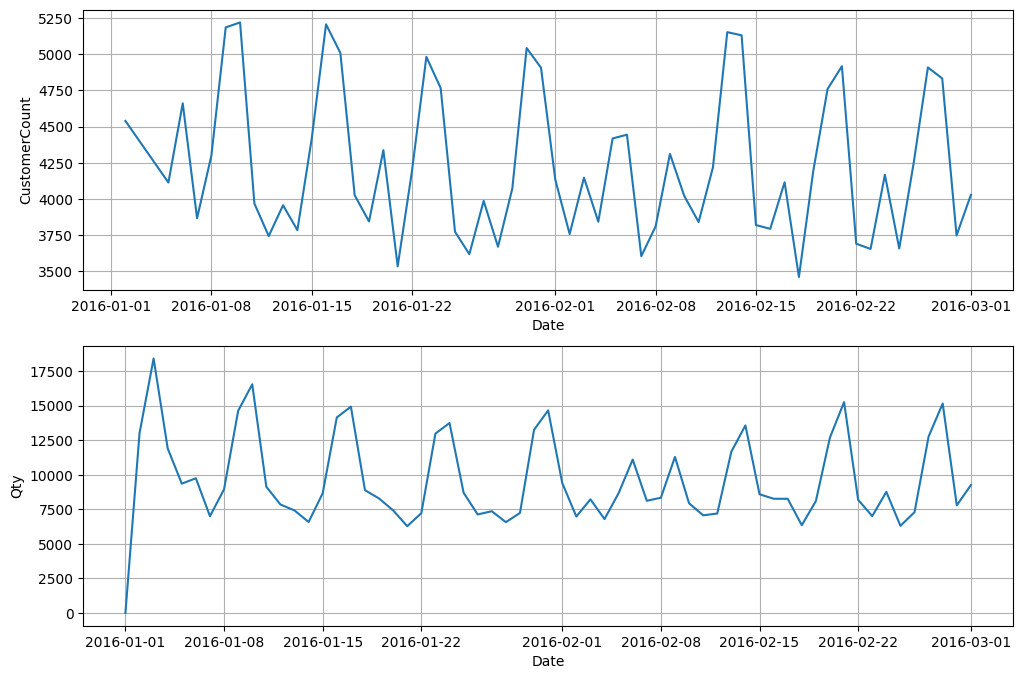

In [ ]:
custCount_trends_product(3, '2016-01-01', '2016-03-01')

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
14,12,GA001,Milk,Food,3,6


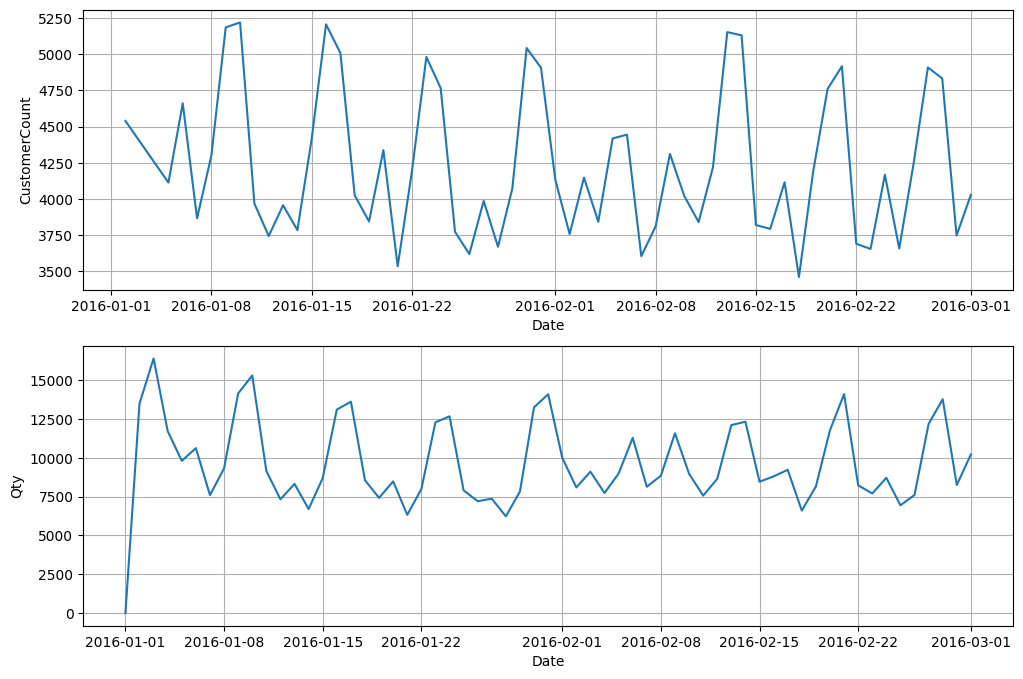

In [ ]:
custCount_trends_product(12, '2016-01-01', '2016-03-01')

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
15,42,FM001,Agricultural products,Grocery,3,5


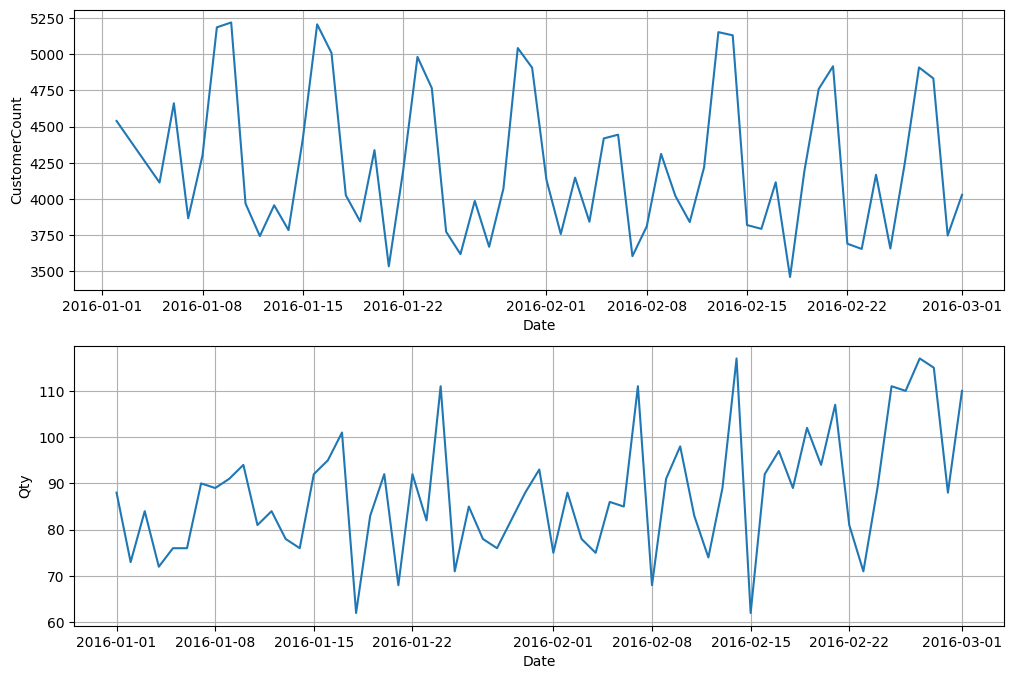

In [ ]:
custCount_trends_product(42, '2016-01-01', '2016-03-01')

## **(2) 시계열 패턴 찾아보기2**

* 변화량과 비교해보기

### 1) 대상 매장(44), 대상 상품의 판매량 추이

In [ ]:
def sales_trends_prod2(Product_ID, sdate, edate):
    display( products.loc[products['Product_ID'].isin([Product_ID])])
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    temp['Qty_diff'] = temp['Qty'].diff()

    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    sns.lineplot(x='Date', y = 'Qty_diff', data = temp)
    plt.grid()
    plt.subplot(1,2,2)
    sns.histplot(x = 'Qty_diff', data = temp, bins = 20)
    plt.grid()
    plt.show()

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
13,3,DB001,Beverage,Drink,2,8


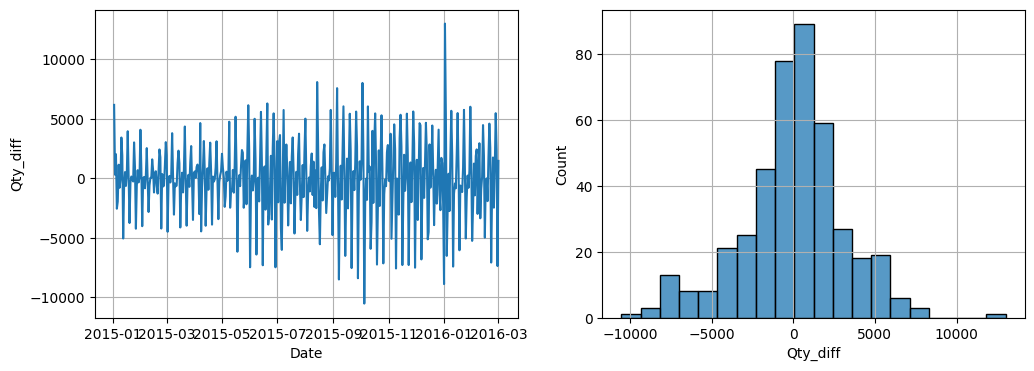

In [ ]:
sales_trends_prod2(3, '2015-01-01', '2016-03-01')

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
14,12,GA001,Milk,Food,3,6


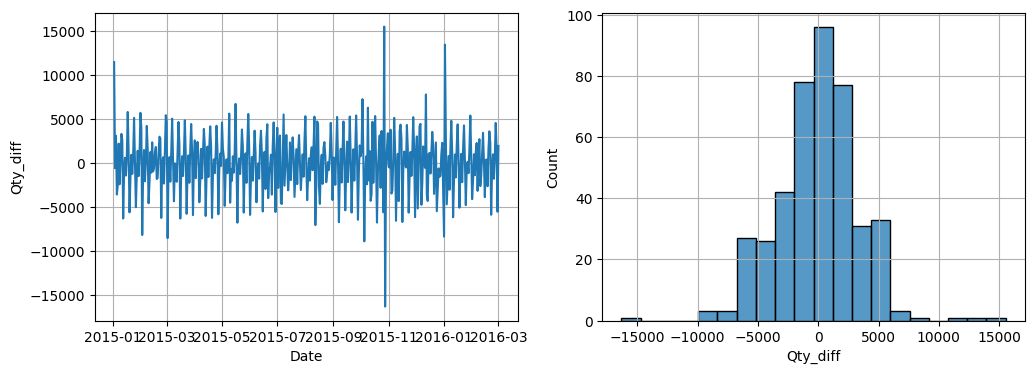

In [ ]:
sales_trends_prod2(12, '2015-01-01', '2016-03-01')

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
15,42,FM001,Agricultural products,Grocery,3,5


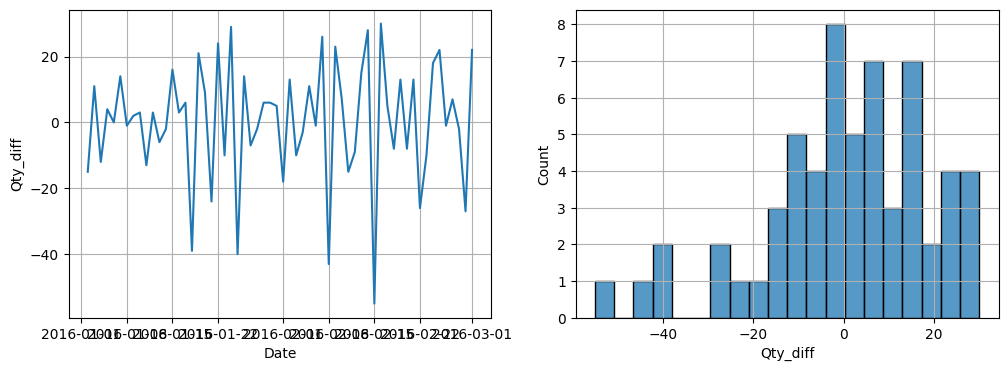

In [ ]:
sales_trends_prod2(42, '2016-01-01', '2016-03-01')

### 2) 요일별 변화량 비교

In [ ]:
def sale_weekday(Product_ID, sdate, edate):
    display( products.loc[products['Product_ID'].isin([Product_ID])])
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    temp['Qty_diff'] = temp['Qty'].diff()
    temp['Weekday'] = temp['Date'].dt.weekday
    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    sns.barplot(x='Weekday', y = 'Qty', data = temp)
    plt.grid()
    plt.subplot(1,2,2)
    sns.barplot(x='Weekday', y = 'Qty_diff', data = temp)
    plt.grid()
    plt.show()

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
13,3,DB001,Beverage,Drink,2,8


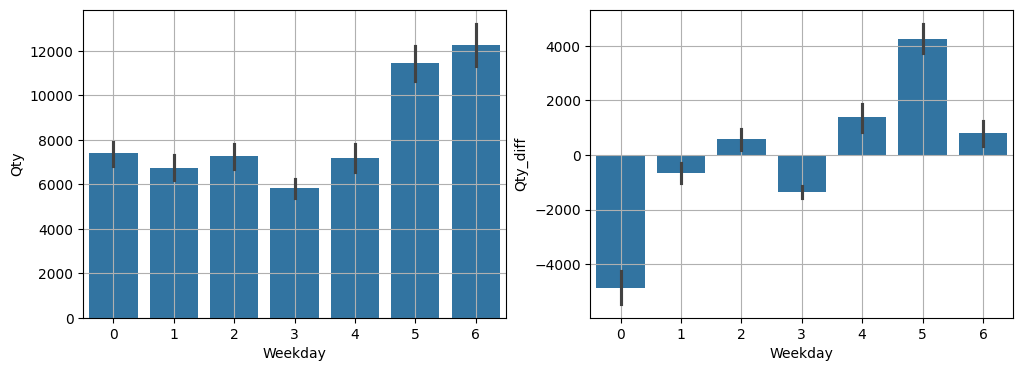

In [ ]:
sale_weekday(3, '2015-01-01', '2016-03-01')

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
7,11,FF001,Frozen,Food,2,29


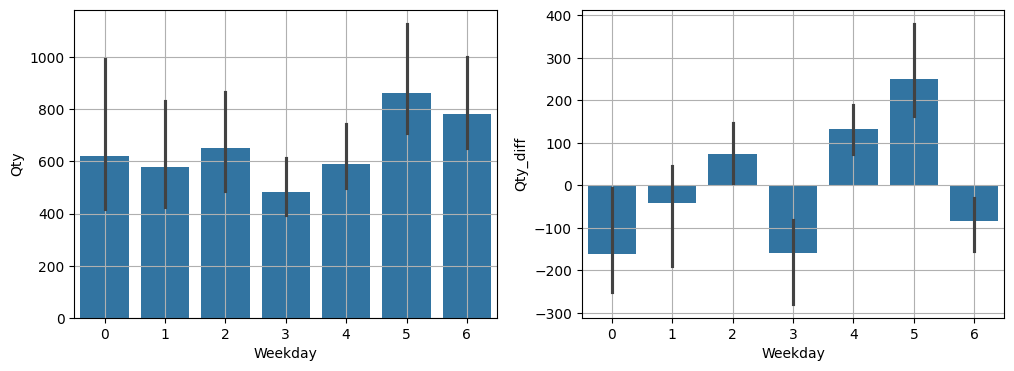

In [ ]:
sale_weekday(11, '2015-01-01', '2016-03-01')

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
15,42,FM001,Agricultural products,Grocery,3,5


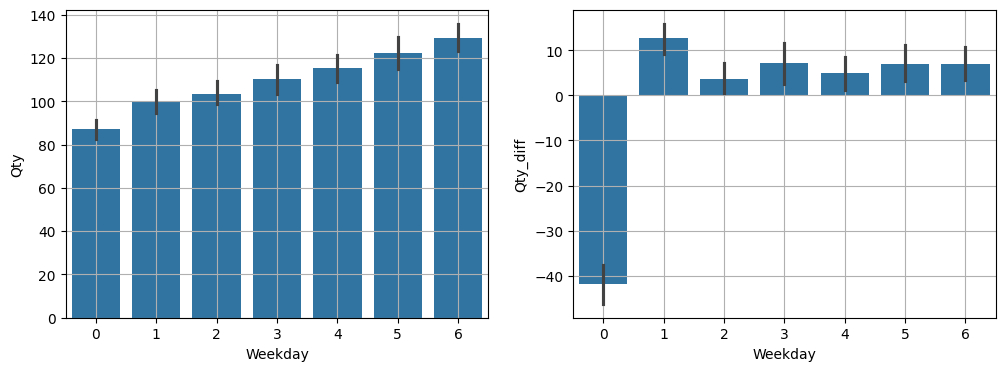

In [ ]:
sale_weekday(42, '2015-01-01', '2016-03-01')

### 3) 시계열 데이터 분해

In [ ]:
def decomp_plot(Product_ID, sdate, edate, period ) :

    # 시계열 데이터 분해
    temp = sales.loc[(sales['Store_ID'] == 44) & (sales['Product_ID'] == Product_ID) & (sales['Date'].between(sdate, edate))]
    decomp = sm.tsa.seasonal_decompose(temp['Qty'], model = 'additive', period = period)

    # 시계열 분해 결과를 받아서 데이터프레임으로 저장
    result = pd.DataFrame({'observed':decomp.observed, 'trend':decomp.trend, 'seasonal':decomp.seasonal, 'residual':decomp.resid})

    # 4개의 그래프로 나눠서 그리기
    plt.figure(figsize=(15, 8))

    plt.subplot(4,1,1)
    plt.plot(result['observed'])
    plt.ylabel('observed')

    plt.subplot(4,1,2)
    plt.plot(result['trend'])
    plt.ylabel('trend')

    plt.subplot(4,1,3)
    plt.plot(result['seasonal'])
    plt.ylabel('seasonal')

    plt.subplot(4,1,4)
    plt.plot(result['residual'])
    plt.ylabel('residual')
    plt.show()

    return result

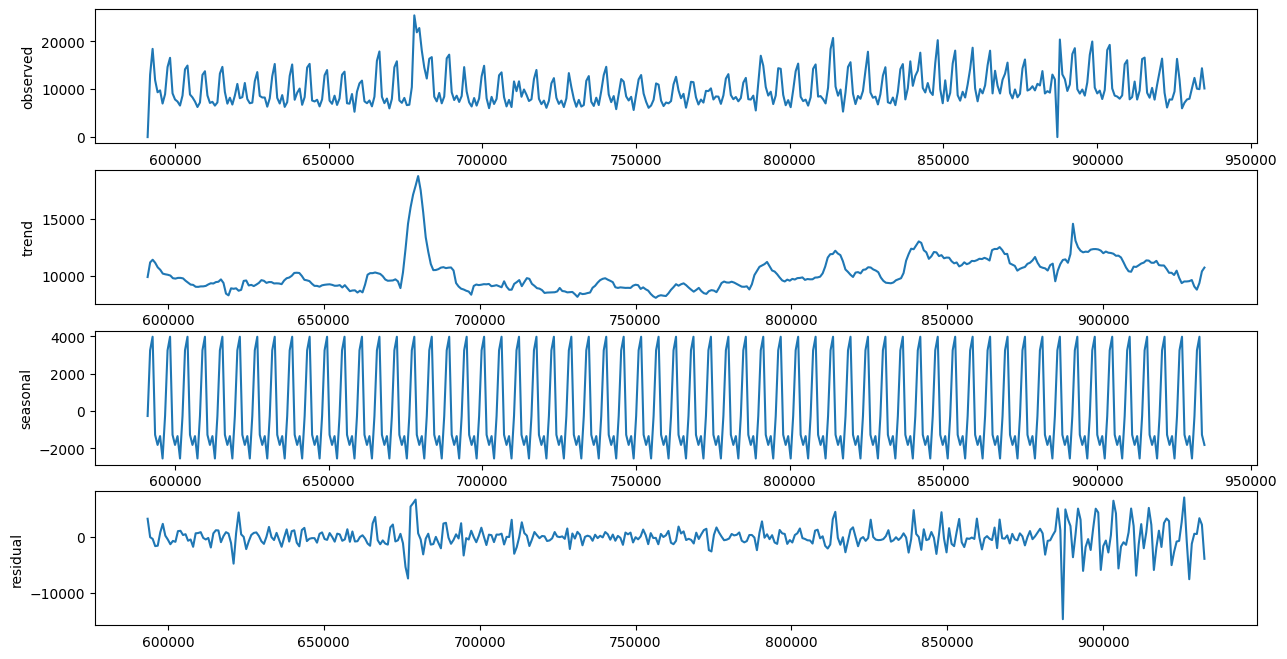

In [ ]:
result = decomp_plot(3, '2016-01-01', '2017-03-01', 7)

In [ ]:
result

,observed,trend,seasonal,residual
591055,0.0,NaN,-265.210567,NaN
591866,13006.0,NaN,3252.187052,NaN
592677,18421.0,NaN,3976.018166,NaN
593488,11911.0,9922.142857,-1271.001043,3259.858186
594299,9361.0,11201.428571,-1812.681996,-27.746576
...,...,...,...,...
931676,12361.0,10418.714286,-265.210567,2207.496282
932487,10108.0,10746.857143,3252.187052,-3891.044195
933298,10006.0,NaN,3976.018166,NaN
934109,14374.0,NaN,-1271.001043,NaN


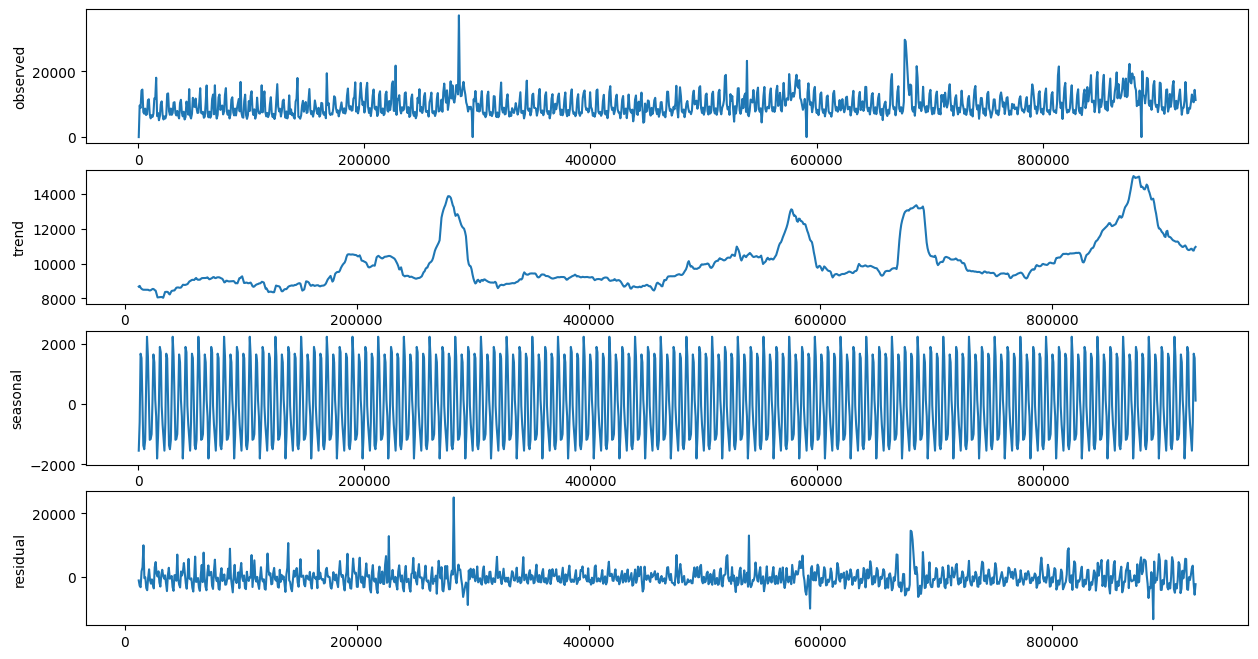

In [ ]:
result = decomp_plot(12, '2014-01-01', '2017-03-01', 28)

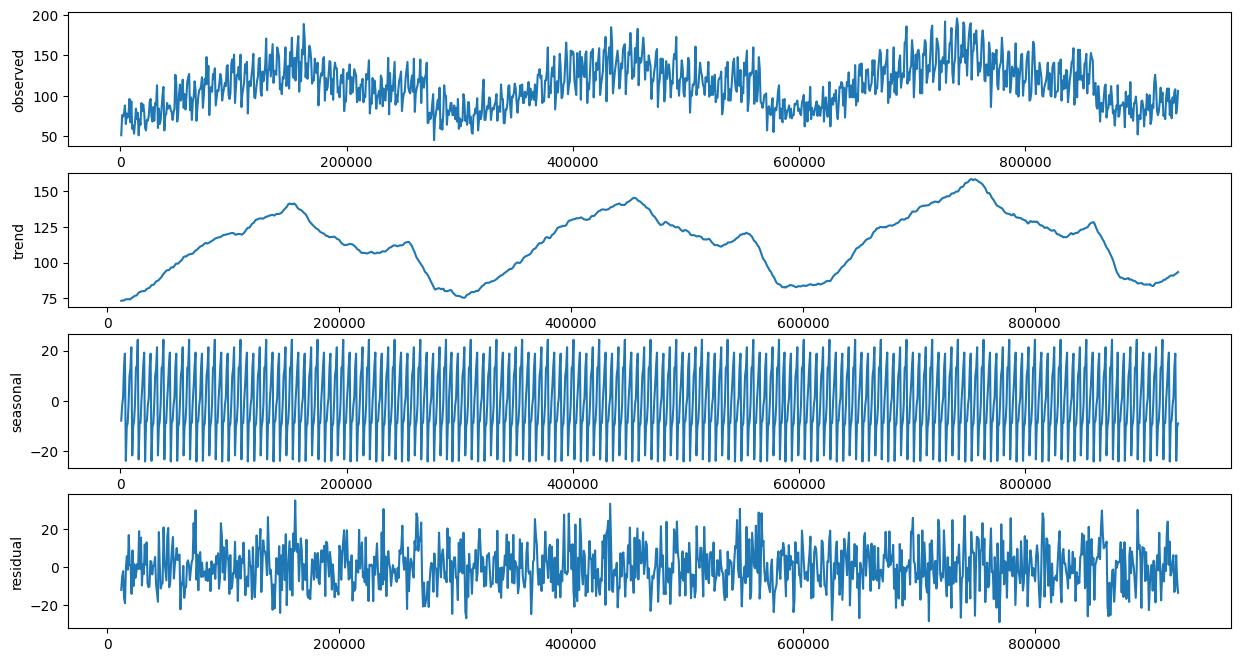

In [ ]:
result = decomp_plot(42, '2014-01-01', '2017-03-01', 28)

# **3.패턴 정리하기**

* 다양한 탐색을 통해 찾은 시계열 패턴을 적어 봅시다.